# Setup

Install the dependencies:
```sh
pip install gym
pip install gym[atari]
```

In [1]:
#!pip install gym
#!pip install gym[atari]

# Useful Resources
* [Manual of the game](https://www.gamesdatabase.org/Media/SYSTEM/Atari_2600/Manual/formated/Freeway_-_1981_-_Zellers.pdf)
* [Freeway Disassembly](http://www.bjars.com/disassemblies.html)
* [Atari Ram Annotations](https://github.com/mila-iqia/atari-representation-learning/blob/master/atariari/benchmark/ram_annotations.py)
* [Freeway Benchmarks](https://paperswithcode.com/sota/atari-games-on-atari-2600-freeway)

# Description of the problem

TODO

# Imports

In [1]:
import sys
sys.path.append('../')  # Enable importing from `src` folder

In [2]:
%matplotlib inline
from collections import defaultdict
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots

In [3]:
def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

# Environment

We will be using the Open AI Gym framework in this study.......

In [5]:
env, initial_state = environment.get_env()

print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)

Action Space: Discrete(3)
Observation Space: Box(0, 255, (128,), uint8)


The agent in this game has three possible actions:

* 0: Stay
* 1: Move forward
* 2: Move back

TODO: Talk a bit about the observation space of 128 bytes of RAM...

# Baseline

As a simple baseline, we are using an agent that moves always **up**.

In [6]:
#baseline_scores = environment.run(agents.Baseline, render=False, n_runs=10, verbose=False)

In [7]:
#with open("baseline_scores.txt", "w") as f:
#    for item in baseline_scores:
#        f.write("%s\n" % item)

In [32]:
with open("baseline_scores.txt") as f:
    baseline_scores = [int(x) for x in  f.read().splitlines()]

In [33]:
# Mean score
baseline_mean_score = sum(baseline_scores) / len(baseline_scores) 
print("Baseline mean score:", baseline_mean_score)

Baseline mean score: 21.2


It usually scores from 21 to 23 points, as shown in the images below:

![Baseline 1](./img/baseline_1.png)
![Baseline 2](./img/baseline_2.png)

# Representing the state of the game

TODO: explain why we must reduce the state space

```
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 18  # Chicken Collision flag (with the bottom car)
    , 22  # Car X Direction
    , 23, 24, 25, 26, 27, 28, 29, 30, 31, 32  # Z Car Patterns
    , 33, 34, 35, 36, 37, 38, 39, 40, 41, 42  # Car Motion Timmers
    , 43, 44, 45, 46, 47, 48, 49, 50, 51, 52  # Car Motions
    , 87, 88  # Car Shape Ptr
    # TODO: test if this makes any difference
    , 89, 90  # Chicken Shape Ptr
    # TODO: test if this makes any difference
    , 106, 107  # Chicken Sounds
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
```

In [4]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

In [5]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position 
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 19 or ob[b] > 79:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space 
            ob[b] = ob[b] // 3

    return ob

# Reward Policy

In [6]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
       
    elif action == 0:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL
        
    elif action == 1:  # incentivate going forward
        reward = reward_policy.REWARD_IF_FW
    
    elif action == 2:  # Don't incentivate moving back
        reward = reward_policy.REWARD_IF_BW

    return reward

# Hyper Parameters

In [7]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 3
N0 = 2.5

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 
reward_policy.REWARD_IF_BW = -9

n_runs_q = 7001
n_runs_mc = 7001

# Q-Learning

### Hyper Parameters: ɣ=0.99, N0=2.5, 3 actions

In [13]:
#env, initial_state = environment.get_env()
#agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

#scores_1p = []
#total_rewards_1p = []

In [14]:
# %%time
# n_runs = n_runs_q
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#
#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
#    
#     score = 0
#     total_reward = 0
#
#     while not game_over:
#         if render:
#             time.sleep(0.015)
#             env.render()
#
#         old_state = state
#         ob, reward, game_over, _ = env.step(action)
#
#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)
#
#         total_reward += reward
#
#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1
#
#         state = ob[RAM_mask].data.tobytes()
#
#         agent.update_Q(old_state, state, action, reward)
#
#         action = agent.act(state)  # Next action
#
#     scores_1p.append(score)
#     total_rewards_1p.append(total_reward)
#   
#     print_result(i, scores_1p, total_reward, score)

Run [   0] - Total reward: -9590.00 Mean scores: 0.00 Means Scores[:-10]:  0.00 Score:  0 
Run [  10] - Total reward: -8283.00 Mean scores: 0.00 Means Scores[:-10]:  0.00 Score:  0 
Run [  20] - Total reward: -7934.00 Mean scores: 0.00 Means Scores[:-10]:  0.00 Score:  0 
Run [  30] - Total reward: -6853.00 Mean scores: 0.03 Means Scores[:-10]:  0.10 Score:  1 
Run [  40] - Total reward: -7348.00 Mean scores: 0.05 Means Scores[:-10]:  0.10 Score:  0 
Run [  50] - Total reward: -7743.00 Mean scores: 0.29 Means Scores[:-10]:  1.30 Score:  0 
Run [  60] - Total reward: -4869.00 Mean scores: 0.56 Means Scores[:-10]:  1.90 Score:  4 
Run [  70] - Total reward: -5118.00 Mean scores: 1.08 Means Scores[:-10]:  4.30 Score:  3 
Run [  80] - Total reward: -3891.00 Mean scores: 1.59 Means Scores[:-10]:  5.20 Score:  5 
Run [  90] - Total reward: -3517.00 Mean scores: 2.16 Means Scores[:-10]:  6.80 Score:  5 
Run [ 100] - Total reward: -689.00 Mean scores: 2.70 Means Scores[:-10]:  7.60 Score: 10 


Run [ 910] - Total reward: 8782.00 Mean scores: 15.96 Means Scores[:-10]: 21.40 Score: 22 
Run [ 920] - Total reward: 8558.00 Mean scores: 16.02 Means Scores[:-10]: 21.40 Score: 21 
Run [ 930] - Total reward: 8414.00 Mean scores: 16.08 Means Scores[:-10]: 21.30 Score: 21 
Run [ 940] - Total reward: 9472.00 Mean scores: 16.15 Means Scores[:-10]: 22.60 Score: 23 
Run [ 950] - Total reward: 9046.00 Mean scores: 16.21 Means Scores[:-10]: 22.00 Score: 22 
Run [ 960] - Total reward: 9674.00 Mean scores: 16.28 Means Scores[:-10]: 22.90 Score: 23 
Run [ 970] - Total reward: 8401.00 Mean scores: 16.34 Means Scores[:-10]: 21.80 Score: 22 
Run [ 980] - Total reward: 9661.00 Mean scores: 16.39 Means Scores[:-10]: 21.70 Score: 23 
Run [ 990] - Total reward: 7863.00 Mean scores: 16.45 Means Scores[:-10]: 22.40 Score: 20 
Run [1000] - Total reward: 7779.00 Mean scores: 16.51 Means Scores[:-10]: 22.30 Score: 20 
Run [1010] - Total reward: 9001.00 Mean scores: 16.56 Means Scores[:-10]: 21.70 Score: 22 

Run [1810] - Total reward: 11044.00 Mean scores: 19.67 Means Scores[:-10]: 25.10 Score: 25 
Run [1820] - Total reward: 12816.00 Mean scores: 19.70 Means Scores[:-10]: 25.90 Score: 28 
Run [1830] - Total reward: 11234.00 Mean scores: 19.74 Means Scores[:-10]: 26.00 Score: 25 
Run [1840] - Total reward: 10562.00 Mean scores: 19.76 Means Scores[:-10]: 24.90 Score: 24 
Run [1850] - Total reward: 11651.00 Mean scores: 19.79 Means Scores[:-10]: 24.50 Score: 26 
Run [1860] - Total reward: 11592.00 Mean scores: 19.82 Means Scores[:-10]: 26.00 Score: 26 
Run [1870] - Total reward: 9903.00 Mean scores: 19.85 Means Scores[:-10]: 25.20 Score: 23 
Run [1880] - Total reward: 11094.00 Mean scores: 19.88 Means Scores[:-10]: 26.20 Score: 25 
Run [1890] - Total reward: 11035.00 Mean scores: 19.92 Means Scores[:-10]: 25.80 Score: 25 
Run [1900] - Total reward: 9957.00 Mean scores: 19.94 Means Scores[:-10]: 24.70 Score: 23 
Run [1910] - Total reward: 10407.00 Mean scores: 19.97 Means Scores[:-10]: 25.80 S

Run [2710] - Total reward: 13427.00 Mean scores: 21.85 Means Scores[:-10]: 26.80 Score: 29 
Run [2720] - Total reward: 12262.00 Mean scores: 21.87 Means Scores[:-10]: 26.20 Score: 27 
Run [2730] - Total reward: 12490.00 Mean scores: 21.88 Means Scores[:-10]: 26.70 Score: 27 
Run [2740] - Total reward: 14242.00 Mean scores: 21.90 Means Scores[:-10]: 27.60 Score: 30 
Run [2750] - Total reward: 12828.00 Mean scores: 21.92 Means Scores[:-10]: 27.40 Score: 28 
Run [2760] - Total reward: 11754.00 Mean scores: 21.95 Means Scores[:-10]: 27.80 Score: 26 
Run [2770] - Total reward: 12982.00 Mean scores: 21.97 Means Scores[:-10]: 27.60 Score: 28 
Run [2780] - Total reward: 12880.00 Mean scores: 21.98 Means Scores[:-10]: 27.20 Score: 28 
Run [2790] - Total reward: 13395.00 Mean scores: 22.01 Means Scores[:-10]: 27.90 Score: 29 
Run [2800] - Total reward: 11133.00 Mean scores: 22.02 Means Scores[:-10]: 27.30 Score: 25 
Run [2810] - Total reward: 13656.00 Mean scores: 22.04 Means Scores[:-10]: 27.10

Run [3610] - Total reward: 12506.00 Mean scores: 23.33 Means Scores[:-10]: 27.70 Score: 27 
Run [3620] - Total reward: 13571.00 Mean scores: 23.34 Means Scores[:-10]: 28.30 Score: 29 
Run [3630] - Total reward: 14128.00 Mean scores: 23.35 Means Scores[:-10]: 29.00 Score: 30 
Run [3640] - Total reward: 13119.00 Mean scores: 23.37 Means Scores[:-10]: 29.00 Score: 28 
Run [3650] - Total reward: 14747.00 Mean scores: 23.38 Means Scores[:-10]: 28.60 Score: 31 
Run [3660] - Total reward: 13658.00 Mean scores: 23.40 Means Scores[:-10]: 28.10 Score: 29 
Run [3670] - Total reward: 14174.00 Mean scores: 23.41 Means Scores[:-10]: 28.80 Score: 30 
Run [3680] - Total reward: 11985.00 Mean scores: 23.42 Means Scores[:-10]: 27.90 Score: 26 
Run [3690] - Total reward: 13459.00 Mean scores: 23.44 Means Scores[:-10]: 28.60 Score: 29 
Run [3700] - Total reward: 13070.00 Mean scores: 23.45 Means Scores[:-10]: 28.30 Score: 28 
Run [3710] - Total reward: 13075.00 Mean scores: 23.46 Means Scores[:-10]: 28.40

Run [4510] - Total reward: 13654.00 Mean scores: 24.35 Means Scores[:-10]: 29.00 Score: 29 
Run [4520] - Total reward: 15347.00 Mean scores: 24.36 Means Scores[:-10]: 29.50 Score: 32 
Run [4530] - Total reward: 13568.00 Mean scores: 24.37 Means Scores[:-10]: 28.70 Score: 29 
Run [4540] - Total reward: 12507.00 Mean scores: 24.38 Means Scores[:-10]: 28.30 Score: 27 
Run [4550] - Total reward: 13665.00 Mean scores: 24.39 Means Scores[:-10]: 29.70 Score: 29 
Run [4560] - Total reward: 13642.00 Mean scores: 24.40 Means Scores[:-10]: 29.30 Score: 29 
Run [4570] - Total reward: 13008.00 Mean scores: 24.41 Means Scores[:-10]: 29.20 Score: 28 
Run [4580] - Total reward: 14191.00 Mean scores: 24.42 Means Scores[:-10]: 29.10 Score: 30 
Run [4590] - Total reward: 13744.00 Mean scores: 24.43 Means Scores[:-10]: 29.00 Score: 29 
Run [4600] - Total reward: 14159.00 Mean scores: 24.44 Means Scores[:-10]: 29.20 Score: 30 
Run [4610] - Total reward: 14830.00 Mean scores: 24.45 Means Scores[:-10]: 29.30

Run [5410] - Total reward: 13190.00 Mean scores: 25.12 Means Scores[:-10]: 28.90 Score: 28 
Run [5420] - Total reward: 14733.00 Mean scores: 25.13 Means Scores[:-10]: 29.30 Score: 31 
Run [5430] - Total reward: 14274.00 Mean scores: 25.14 Means Scores[:-10]: 29.90 Score: 30 
Run [5440] - Total reward: 14115.00 Mean scores: 25.15 Means Scores[:-10]: 30.10 Score: 30 
Run [5450] - Total reward: 14775.00 Mean scores: 25.16 Means Scores[:-10]: 30.30 Score: 31 
Run [5460] - Total reward: 13715.00 Mean scores: 25.16 Means Scores[:-10]: 28.50 Score: 29 
Run [5470] - Total reward: 13512.00 Mean scores: 25.17 Means Scores[:-10]: 28.90 Score: 29 
Run [5480] - Total reward: 12972.00 Mean scores: 25.18 Means Scores[:-10]: 29.00 Score: 28 
Run [5490] - Total reward: 13023.00 Mean scores: 25.18 Means Scores[:-10]: 28.20 Score: 28 
Run [5500] - Total reward: 14274.00 Mean scores: 25.19 Means Scores[:-10]: 28.90 Score: 30 
Run [5510] - Total reward: 11907.00 Mean scores: 25.20 Means Scores[:-10]: 28.90

Run [6310] - Total reward: 15345.00 Mean scores: 25.70 Means Scores[:-10]: 30.20 Score: 32 
Run [6320] - Total reward: 14205.00 Mean scores: 25.70 Means Scores[:-10]: 29.60 Score: 30 
Run [6330] - Total reward: 14284.00 Mean scores: 25.71 Means Scores[:-10]: 29.40 Score: 30 
Run [6340] - Total reward: 13082.00 Mean scores: 25.71 Means Scores[:-10]: 28.80 Score: 28 
Run [6350] - Total reward: 13704.00 Mean scores: 25.72 Means Scores[:-10]: 30.00 Score: 29 
Run [6360] - Total reward: 14191.00 Mean scores: 25.73 Means Scores[:-10]: 30.50 Score: 30 
Run [6370] - Total reward: 13802.00 Mean scores: 25.74 Means Scores[:-10]: 30.20 Score: 29 
Run [6380] - Total reward: 13640.00 Mean scores: 25.74 Means Scores[:-10]: 29.70 Score: 29 
Run [6390] - Total reward: 15429.00 Mean scores: 25.75 Means Scores[:-10]: 29.80 Score: 32 
Run [6400] - Total reward: 12551.00 Mean scores: 25.75 Means Scores[:-10]: 28.90 Score: 27 
Run [6410] - Total reward: 13683.00 Mean scores: 25.76 Means Scores[:-10]: 29.00

In [15]:
#len(agent.Q)

218881

In [16]:
#import csv
#dict = agent.Q
#w = csv.writer(open("QL_Qtable_std.csv", "w"))
#for key, val in dict.items():
#    w.writerow([key, val])
  

In [17]:
#dict = agent.Q
#f = open("QL_Qtable_std.txt","w")
#f.write( str(dict) )
#f.close()

In [20]:
#with open("qlearning_scores_std.txt", "w") as f:
#    for item in scores_1p:
#        f.write("%s\n" % item)

#with open("qlearning_total_rewards_std.txt", "w") as f:
#    for item in total_rewards_1p:
#        f.write("%s\n" % item)

In [24]:
with open("qlearning_scores_std.txt") as f:
    scores_std = [int(x) for x in  f.read().splitlines()]

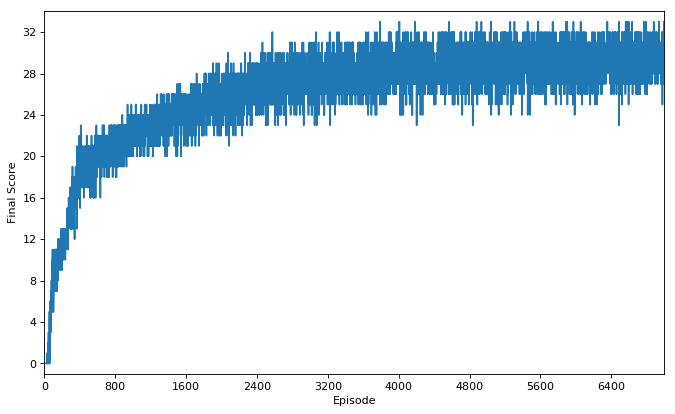

In [25]:
aux_plots.plot_scores(scores_std)

## 1) Influence of the discount Factor

### Changing the discount factor: ɣ=0.90 (N0=2.5, 3 actions)

In [21]:
# GAMMA = 0.90
# env, initial_state = environment.get_env()
# agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)
#
# scores_10p = []
# total_rewards_10p = []

In [22]:
# %%time
# n_runs = n_runs_q
#
# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0
#
#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
#    
#     score = 0
#     total_reward = 0
#
#     while not game_over:
#         if render:
#             time.sleep(0.025)
#             env.render()
#
#         old_state = state
#         ob, reward, game_over, _ = env.step(action)
#
#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)
#
#         total_reward += reward
#
#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1
#
#         state = ob[RAM_mask].data.tobytes()
#
#         agent.update_Q(old_state, state, action, reward)
#
#         action = agent.act(state)  # Next action
#
#     scores_10p.append(score)
#     total_rewards_10p.append(total_reward)
#   
#     print_result(i, scores_10p, total_reward, score)

Run [   0] - Total reward: -9178.00 Mean scores: 0.00 Means Scores[:-10]:  0.00 Score:  0 
Run [  10] - Total reward: -8058.00 Mean scores: 0.00 Means Scores[:-10]:  0.00 Score:  0 
Run [  20] - Total reward: -7762.00 Mean scores: 0.00 Means Scores[:-10]:  0.00 Score:  0 
Run [  30] - Total reward: -7770.00 Mean scores: 0.03 Means Scores[:-10]:  0.10 Score:  0 
Run [  40] - Total reward: -6904.00 Mean scores: 0.07 Means Scores[:-10]:  0.20 Score:  1 
Run [  50] - Total reward: -6394.00 Mean scores: 0.25 Means Scores[:-10]:  1.00 Score:  2 
Run [  60] - Total reward: -5047.00 Mean scores: 0.57 Means Scores[:-10]:  2.20 Score:  4 
Run [  70] - Total reward: -4630.00 Mean scores: 0.97 Means Scores[:-10]:  3.40 Score:  4 
Run [  80] - Total reward: -4131.00 Mean scores: 1.47 Means Scores[:-10]:  5.00 Score:  5 
Run [  90] - Total reward: -3007.00 Mean scores: 2.00 Means Scores[:-10]:  6.30 Score:  6 
Run [ 100] - Total reward: -2651.00 Mean scores: 2.50 Means Scores[:-10]:  7.10 Score:  7 

Run [ 910] - Total reward: 8339.00 Mean scores: 16.02 Means Scores[:-10]: 22.10 Score: 21 
Run [ 920] - Total reward: 8388.00 Mean scores: 16.09 Means Scores[:-10]: 22.00 Score: 21 
Run [ 930] - Total reward: 8919.00 Mean scores: 16.15 Means Scores[:-10]: 21.40 Score: 22 
Run [ 940] - Total reward: 9704.00 Mean scores: 16.21 Means Scores[:-10]: 21.90 Score: 23 
Run [ 950] - Total reward: 8105.00 Mean scores: 16.27 Means Scores[:-10]: 22.50 Score: 21 
Run [ 960] - Total reward: 9565.00 Mean scores: 16.34 Means Scores[:-10]: 22.40 Score: 23 
Run [ 970] - Total reward: 9750.00 Mean scores: 16.39 Means Scores[:-10]: 21.60 Score: 23 
Run [ 980] - Total reward: 7993.00 Mean scores: 16.45 Means Scores[:-10]: 21.90 Score: 20 
Run [ 990] - Total reward: 8418.00 Mean scores: 16.51 Means Scores[:-10]: 22.20 Score: 21 
Run [1000] - Total reward: 10080.00 Mean scores: 16.57 Means Scores[:-10]: 23.00 Score: 24 
Run [1010] - Total reward: 9919.00 Mean scores: 16.63 Means Scores[:-10]: 22.40 Score: 24

Run [1810] - Total reward: 12111.00 Mean scores: 19.90 Means Scores[:-10]: 26.30 Score: 27 
Run [1820] - Total reward: 11909.00 Mean scores: 19.94 Means Scores[:-10]: 25.50 Score: 26 
Run [1830] - Total reward: 11985.00 Mean scores: 19.97 Means Scores[:-10]: 26.00 Score: 27 
Run [1840] - Total reward: 10663.00 Mean scores: 20.00 Means Scores[:-10]: 26.20 Score: 24 
Run [1850] - Total reward: 12187.00 Mean scores: 20.03 Means Scores[:-10]: 25.80 Score: 27 
Run [1860] - Total reward: 12802.00 Mean scores: 20.06 Means Scores[:-10]: 25.50 Score: 28 
Run [1870] - Total reward: 11634.00 Mean scores: 20.09 Means Scores[:-10]: 25.60 Score: 26 
Run [1880] - Total reward: 10638.00 Mean scores: 20.12 Means Scores[:-10]: 26.20 Score: 24 
Run [1890] - Total reward: 10431.00 Mean scores: 20.15 Means Scores[:-10]: 25.80 Score: 24 
Run [1900] - Total reward: 12094.00 Mean scores: 20.19 Means Scores[:-10]: 26.40 Score: 27 
Run [1910] - Total reward: 12746.00 Mean scores: 20.22 Means Scores[:-10]: 25.70

Run [2710] - Total reward: 13562.00 Mean scores: 22.22 Means Scores[:-10]: 28.20 Score: 29 
Run [2720] - Total reward: 12950.00 Mean scores: 22.23 Means Scores[:-10]: 26.50 Score: 28 
Run [2730] - Total reward: 11610.00 Mean scores: 22.25 Means Scores[:-10]: 27.20 Score: 26 
Run [2740] - Total reward: 13519.00 Mean scores: 22.27 Means Scores[:-10]: 28.00 Score: 29 
Run [2750] - Total reward: 11228.00 Mean scores: 22.29 Means Scores[:-10]: 26.90 Score: 25 
Run [2760] - Total reward: 12199.00 Mean scores: 22.31 Means Scores[:-10]: 27.80 Score: 27 
Run [2770] - Total reward: 13513.00 Mean scores: 22.33 Means Scores[:-10]: 27.60 Score: 29 
Run [2780] - Total reward: 12410.00 Mean scores: 22.35 Means Scores[:-10]: 27.60 Score: 27 
Run [2790] - Total reward: 13036.00 Mean scores: 22.37 Means Scores[:-10]: 28.10 Score: 28 
Run [2800] - Total reward: 12244.00 Mean scores: 22.39 Means Scores[:-10]: 28.00 Score: 27 
Run [2810] - Total reward: 10282.00 Mean scores: 22.41 Means Scores[:-10]: 27.20

Run [3610] - Total reward: 13122.00 Mean scores: 23.73 Means Scores[:-10]: 27.90 Score: 28 
Run [3620] - Total reward: 14693.00 Mean scores: 23.74 Means Scores[:-10]: 28.10 Score: 31 
Run [3630] - Total reward: 14150.00 Mean scores: 23.75 Means Scores[:-10]: 28.80 Score: 30 
Run [3640] - Total reward: 14204.00 Mean scores: 23.77 Means Scores[:-10]: 28.80 Score: 30 
Run [3650] - Total reward: 13581.00 Mean scores: 23.78 Means Scores[:-10]: 28.70 Score: 29 
Run [3660] - Total reward: 13149.00 Mean scores: 23.80 Means Scores[:-10]: 29.20 Score: 28 
Run [3670] - Total reward: 13614.00 Mean scores: 23.81 Means Scores[:-10]: 28.80 Score: 29 
Run [3680] - Total reward: 12423.00 Mean scores: 23.82 Means Scores[:-10]: 28.10 Score: 27 
Run [3690] - Total reward: 14055.00 Mean scores: 23.84 Means Scores[:-10]: 29.20 Score: 30 
Run [3700] - Total reward: 12529.00 Mean scores: 23.85 Means Scores[:-10]: 28.00 Score: 27 
Run [3710] - Total reward: 14101.00 Mean scores: 23.86 Means Scores[:-10]: 29.20

Run [4510] - Total reward: 13702.00 Mean scores: 24.77 Means Scores[:-10]: 29.60 Score: 29 
Run [4520] - Total reward: 14226.00 Mean scores: 24.78 Means Scores[:-10]: 29.60 Score: 30 
Run [4530] - Total reward: 13643.00 Mean scores: 24.79 Means Scores[:-10]: 28.90 Score: 29 
Run [4540] - Total reward: 14295.00 Mean scores: 24.80 Means Scores[:-10]: 28.70 Score: 30 
Run [4550] - Total reward: 14865.00 Mean scores: 24.81 Means Scores[:-10]: 30.00 Score: 31 
Run [4560] - Total reward: 13727.00 Mean scores: 24.82 Means Scores[:-10]: 29.90 Score: 29 
Run [4570] - Total reward: 15278.00 Mean scores: 24.83 Means Scores[:-10]: 29.70 Score: 32 
Run [4580] - Total reward: 14322.00 Mean scores: 24.84 Means Scores[:-10]: 29.20 Score: 30 
Run [4590] - Total reward: 15918.00 Mean scores: 24.85 Means Scores[:-10]: 29.80 Score: 33 
Run [4600] - Total reward: 13696.00 Mean scores: 24.86 Means Scores[:-10]: 28.90 Score: 29 
Run [4610] - Total reward: 12518.00 Mean scores: 24.87 Means Scores[:-10]: 29.00

Run [5410] - Total reward: 13751.00 Mean scores: 25.51 Means Scores[:-10]: 28.80 Score: 29 
Run [5420] - Total reward: 14332.00 Mean scores: 25.51 Means Scores[:-10]: 28.80 Score: 30 
Run [5430] - Total reward: 13764.00 Mean scores: 25.52 Means Scores[:-10]: 28.80 Score: 29 
Run [5440] - Total reward: 14317.00 Mean scores: 25.53 Means Scores[:-10]: 29.10 Score: 30 
Run [5450] - Total reward: 14307.00 Mean scores: 25.53 Means Scores[:-10]: 29.40 Score: 30 
Run [5460] - Total reward: 13113.00 Mean scores: 25.54 Means Scores[:-10]: 28.90 Score: 28 
Run [5470] - Total reward: 13193.00 Mean scores: 25.55 Means Scores[:-10]: 29.10 Score: 28 
Run [5480] - Total reward: 14284.00 Mean scores: 25.55 Means Scores[:-10]: 28.40 Score: 30 
Run [5490] - Total reward: 13707.00 Mean scores: 25.56 Means Scores[:-10]: 29.00 Score: 29 
Run [5500] - Total reward: 15448.00 Mean scores: 25.57 Means Scores[:-10]: 30.30 Score: 32 
Run [5510] - Total reward: 15322.00 Mean scores: 25.57 Means Scores[:-10]: 28.50

Run [6310] - Total reward: 13114.00 Mean scores: 26.07 Means Scores[:-10]: 28.90 Score: 28 
Run [6320] - Total reward: 14239.00 Mean scores: 26.08 Means Scores[:-10]: 29.00 Score: 30 
Run [6330] - Total reward: 14207.00 Mean scores: 26.08 Means Scores[:-10]: 29.40 Score: 30 
Run [6340] - Total reward: 14320.00 Mean scores: 26.09 Means Scores[:-10]: 30.00 Score: 30 
Run [6350] - Total reward: 13002.00 Mean scores: 26.09 Means Scores[:-10]: 28.70 Score: 28 
Run [6360] - Total reward: 13667.00 Mean scores: 26.10 Means Scores[:-10]: 29.40 Score: 29 
Run [6370] - Total reward: 15458.00 Mean scores: 26.10 Means Scores[:-10]: 29.70 Score: 32 
Run [6380] - Total reward: 13674.00 Mean scores: 26.11 Means Scores[:-10]: 29.80 Score: 29 
Run [6390] - Total reward: 14828.00 Mean scores: 26.11 Means Scores[:-10]: 29.00 Score: 31 
Run [6400] - Total reward: 13675.00 Mean scores: 26.12 Means Scores[:-10]: 29.20 Score: 29 
Run [6410] - Total reward: 13776.00 Mean scores: 26.12 Means Scores[:-10]: 29.40

In [23]:
#len(agent.Q)

218949

In [24]:
#import csv
#dict = agent.Q
#w = csv.writer(open("QL_Qtable_gamma0p90.csv", "w"))
#for key, val in dict.items():
#    w.writerow([key, val])   

In [25]:
#dict = agent.Q
#f = open("QL_Qtable_gamma0p90.txt","w")
#f.write( str(dict) )
#f.close()

In [28]:
#with open("qlearning_scores_gamma0p90.txt", "w") as f:
#    for item in scores_10p:
#        f.write("%s\n" % item)

#with open("qlearning_total_rewards_gamma0p90.txt", "w") as f:
#    for item in total_rewards_10p:
#        f.write("%s\n" % item)

In [27]:
with open("qlearning_scores_gamma0p90.txt") as f:
    scores_10p = [int(x) for x in  f.read().splitlines()]

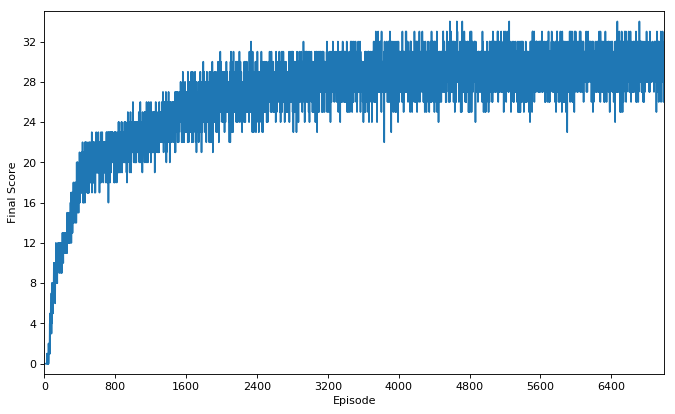

In [28]:
aux_plots.plot_scores(scores_10p)

### Comparison: Mean baseline,  Q-Learning with ɣ=0.99 and ɣ=0.90 (N0=2.5, 3 actions)

In [39]:
import importlib
importlib.reload(aux_plots)

<module 'src.aux_plots' from '/home/aline/Documents/GitHub/FreewayGame/aline.almeida/src/aux_plots.py'>

In [40]:
import src.aux_plots as aux_plots

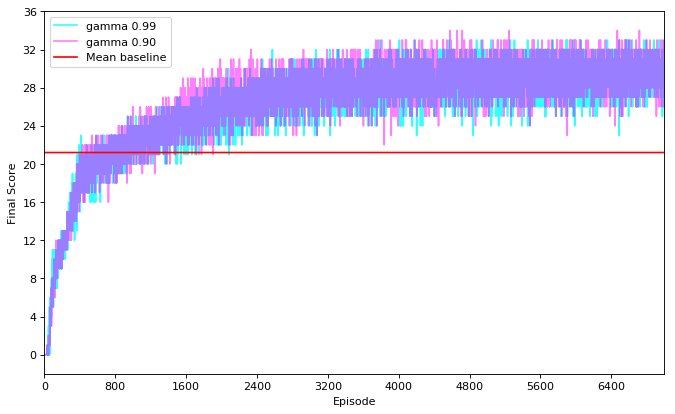

In [42]:
baseline = [baseline_mean_score for i in range(n_runs_q)]
aux_plots.plot_3scores(scores_std, scores_10p, baseline, "gamma 0.99", "gamma 0.90", "Mean baseline")

In [36]:
import statistics 

blocks = n_runs_q//100

scores_std_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(scores_std[b*100:(b+1)*100])
    scores_std_avg100.append(value)
    
scores_10p_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(scores_10p[b*100:(b+1)*100])
    scores_10p_avg100.append(value)

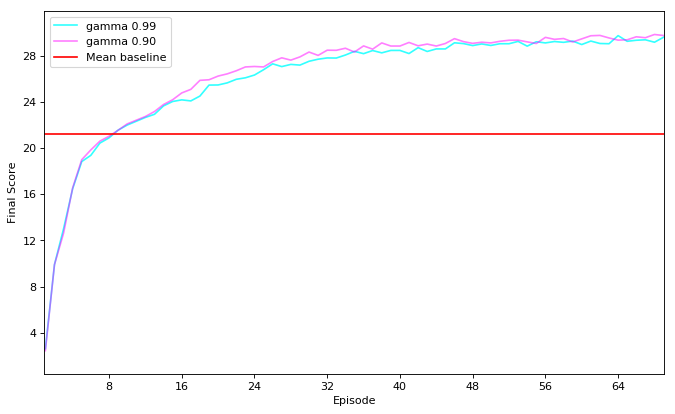

In [43]:
baseline = [baseline_mean_score for i in range(blocks-1)]
aux_plots.plot_3scores(scores_std_avg100, scores_10p_avg100, baseline, "gamma 0.99", "gamma 0.90", "Mean baseline")

## 2) Influence of the learning rate

### Using N0=25 (ɣ=0.99, 3 actions)

In [44]:
N0 = 25
GAMMA = 0.99

env, initial_state = environment.get_env()
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

scores_N025 = []
total_rewards_N025 = []

In [45]:
%%time
n_runs = n_runs_q

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
    
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.025)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores_N025.append(score)
    total_rewards_N025.append(total_reward)
   
    print_result(i, scores_N025, total_reward, score)

Run [   0] - Total reward: -9338.00 Mean scores: 0.00 Means Scores[:-10]:  0.00 Score:  0 


KeyboardInterrupt: 

In [46]:
len(agent.Q)

16970

In [ ]:
import csv
dict = agent.Q
w = csv.writer(open("QL_Qtable_N025.csv", "w"))
for key, val in dict.items():
    w.writerow([key, val])

In [ ]:
dict = agent.Q
f = open("QL_Qtable_N025.txt","w")
f.write( str(dict) )
f.close()

In [ ]:
aux_plots.plot_scores(scores_N025)

In [ ]:
aux_plots.plot_rewards(total_rewards_N025)

In [ ]:
with open("qlearning_scores_N025.txt", "w") as f:
    for item in scores_N025:
        f.write("%s\n" % item)

with open("qlearning_total_rewards_N025.txt", "w") as f:
    for item in total_rewards_N025:
        f.write("%s\n" % item)

In [ ]:
#with open("qlearning_total_rewards_N025_7k_iter.txt") as f:
#    scores_N025 = [int(x) for x in  f.read().splitlines()]

### Comparison: Mean baseline,  Q-Learning with N0=2.5 and N0=25 (ɣ=0.99, 3 actions)

In [38]:
with open("qlearning_scores_std.txt") as f:
    scores_std = [int(x) for x in  f.read().splitlines()]

In [ ]:
baseline = [baseline_mean_score for i in range(n_runs_q)]
aux_plots.plot_3scores(scores_std, scores_N025, baseline, "N0=2.5", "N0=25", "Mean baseline")

# Monte Carlo Control

### Monte Carlo: 

In [ ]:
GAMMA = 0.99
env, initial_state = environment.get_env()
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

In [ ]:
%%time
MonteCarloES(RAM_mask=RAM_mask, render=False)

In [ ]:
scores = []
total_rewards = []

In [ ]:
%%time

n_runs = n_runs_mc

for i in range(n_runs):
    #render = i % 201 == 10
    render = 0
    
    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

In [ ]:
aux_plots.plot_scores(scores)

In [ ]:
aux_plots.plot_rewards(total_rewards)